# News analysis

In [1]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter
from wordcloud import WordCloud
import geopandas as gpd
import plotly.express as px
import spacy
import srsly
import numpy as np

# pd.set_option("display.max_rows", None)
pd.reset_option("display.max_row")


## Cleaning

In [238]:
# Function to clean article texts
def clean_text(text):
    # word_count = articles.loc[articles['article'] == text,'word_count'].iloc[0]
    # if word_count == "":
    #     print("Not here")
    #     return text
    # Remove "All rights reserved"
    if "All Rights Reserved" in text and "Citation" in text:
        newspaper = articles.loc[articles['article'] == text,'newspaper'].iloc[0]

        text = re.sub(r"\n.*?All Rights Reserved\..*", "", text)
        # text = re.sub(r"\n.*?All rights reserved\..*", "", text)
        
        # Remove "Citation (aglc Style)..." at the end of the articles
        text = re.sub(r"Citation \(aglc Style\)\n.*", "", text, flags=re.DOTALL)
        
        # Remove last news outlet occurance
        text = text.split(newspaper, -1)[0]

    # Convert to lowercase
    # text = text.lower()  
    # Remove punctuation and special characters
    # text = re.sub(r'\W+', ' ', text)  
    return text

In [250]:
# import
articles = pd.read_csv('helene_all_articles.csv')

# - date: string to date.time
articles['date'] = pd.to_datetime(articles['date'])

# - author & word_count: fill_na 
articles = articles.fillna('')

articles['title'] = articles['title'].str.lstrip()
# clean text
articles['article_text'] = articles['article'].apply(clean_text)

# handle video footage with only urls but no text
articles.loc[articles['article'].str.startswith('http'), 'article_text'] = articles['title']

articles.head()

,header,article,title,date,newspaper,author,word_count,County,Outlet,article_text
0,"Samaritan’s Purse, Alliance Bible Fellowship e...",BOONE — Samaritan's Purse and Alliance Bible F...,"Samaritan’s Purse, Alliance Bible Fellowship e...",2024-10-02,Watauga Democrat,Luke Barber luke.barber@wataugademocrat.com,593.0,Watauga,Watauga Democrat,BOONE — Samaritan's Purse and Alliance Bible F...
1,Watch out for scammers as recovery efforts mov...,Attorney General Josh Stein declared the state...,Watch out for scammers as recovery efforts mov...,2024-10-02,Watauga Democrat,Ben McNeely,379.0,Watauga,Watauga Democrat,Attorney General Josh Stein declared the state...
2,STORM RECOVERY: Carbon Monoxide Safety\nOctobe...,Widespread power outages due to damage from Hu...,STORM RECOVERY: Carbon Monoxide Safety,2024-10-02,Watauga Democrat,Staff Writer,440.0,Watauga,Watauga Democrat,Widespread power outages due to damage from Hu...
3,Outage restoration continues with more than 40...,More than 300 line technicians consisting of B...,Outage restoration continues with more than 40...,2024-10-02,Watauga Democrat,Moss Brennan moss.brennan@wataugademocrat.com,267.0,Watauga,Watauga Democrat,More than 300 line technicians consisting of B...
4,Virginia commit Hamrick returning to Crest Hig...,University of Virginia recruit and A.C. Reynol...,Virginia commit Hamrick returning to Crest Hig...,2024-10-10,Gaston Gazette,Joe L Hughes II; Shelby Star,344.0,Gaston,The Gaston Gazette,University of Virginia recruit and A.C. Reynol...


Drop duplicates

In [ ]:
# Potential cause: republish or newsbank error
len(articles[articles.duplicated(['title', 'date', 'newspaper', 'word_count'])])    # 6
# Drop these
articles = articles.drop_duplicates(['title', 'date', 'newspaper', 'word_count'])
len(articles)   # 1714

# Save it
# articles.to_csv("helene_all_articles_cleaned.csv", index=False)

# Potential cause: Editing 
len(articles[articles.duplicated(['title', 'newspaper'])])      # 82
# Keep these for update / edit analysis

# Potential cause: Republishing by another newspaper
len(articles[articles.duplicated(['title'])])       # 202
# Keep these for republishing analysis

202

## Analysis

A few research questions to ask:
1. How has the coverage topic changed along time?
2. In which geographical areas are these coverages about, how local are these coverages?
3. What practical information is included for disaster?
4. How many articles are original, how much are republishing?
4. Tone of the news reporting: sentiment analysis?

In [2]:
# Read cleaned articles
articles = pd.read_csv('helene_all_articles_cleaned.csv').fillna("")
articles['date'] = pd.to_datetime(articles['date'], format='%y-%m-%d').dt.strftime('%y-%m-%d') 
articles.head()

,header,article,title,date,newspaper,author,word_count,County,Outlet,article_text
0,"Samaritan’s Purse, Alliance Bible Fellowship e...",BOONE — Samaritan's Purse and Alliance Bible F...,"Samaritan’s Purse, Alliance Bible Fellowship e...",24-10-02,Watauga Democrat,Luke Barber luke.barber@wataugademocrat.com,593.0,Watauga,Watauga Democrat,BOONE — Samaritan's Purse and Alliance Bible F...
1,Watch out for scammers as recovery efforts mov...,Attorney General Josh Stein declared the state...,Watch out for scammers as recovery efforts mov...,24-10-02,Watauga Democrat,Ben McNeely,379.0,Watauga,Watauga Democrat,Attorney General Josh Stein declared the state...
2,STORM RECOVERY: Carbon Monoxide Safety\nOctobe...,Widespread power outages due to damage from Hu...,STORM RECOVERY: Carbon Monoxide Safety,24-10-02,Watauga Democrat,Staff Writer,440.0,Watauga,Watauga Democrat,Widespread power outages due to damage from Hu...
3,Outage restoration continues with more than 40...,More than 300 line technicians consisting of B...,Outage restoration continues with more than 40...,24-10-02,Watauga Democrat,Moss Brennan moss.brennan@wataugademocrat.com,267.0,Watauga,Watauga Democrat,More than 300 line technicians consisting of B...
4,Virginia commit Hamrick returning to Crest Hig...,University of Virginia recruit and A.C. Reynol...,Virginia commit Hamrick returning to Crest Hig...,24-10-10,Gaston Gazette,Joe L Hughes II; Shelby Star,344.0,Gaston,The Gaston Gazette,University of Virginia recruit and A.C. Reynol...


Basic text processing

In [4]:
from nltk.stem import PorterStemmer

# Lowercase and remove special characters
def lower_and_remove_special(text):
    # Convert to lowercase
    text = text.lower()  
    # Remove punctuation and special characters
    text = re.sub(r'\W+', ' ', text)
    return text  

# Stem
stemmer = PorterStemmer()
def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]


# Download stop words
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Because this is all about hurricane helene, remove them as stop-words
stop_words.update(['2024', 'hurricane', 'helene'])

# Another stop word set for news
# stop_df = pd.read_csv('https://raw.githubusercontent.com/vikasing/news-stopwords/refs/heads/master/sw10k.csv')
# stop_words.update(stop_df['term'].to_list())

# Tokenize and remove stop words
def tokenize_and_remove_stopwords(text):
    words = word_tokenize(text)
    return [word for word in words if word not in stop_words]

[nltk_data] Downloading package punkt to /Users/yanans/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yanans/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Lower and remove special characters
articles['cleaned_text'] = articles['article_text'].apply(lower_and_remove_special)
# Remove stop words
articles['tokens'] = articles['cleaned_text'].apply(tokenize_and_remove_stopwords)
# Stem the tokens
articles['stemmed_tokens'] = articles['tokens'].apply(stem_tokens)

### Coverage number changes

In [37]:
date = articles.groupby('date')['article'].count().reset_index()
date

,date,article
0,2024-09-23,2
1,2024-09-24,3
2,2024-09-25,17
3,2024-09-26,31
4,2024-09-27,33
5,2024-09-28,24
6,2024-09-29,38
7,2024-09-30,50
8,2024-10-01,84
9,2024-10-02,107


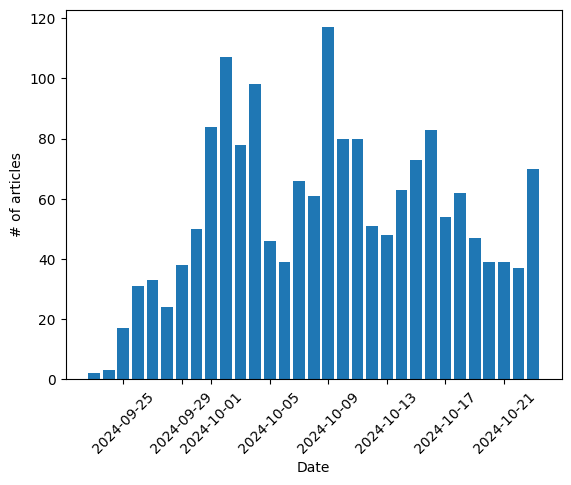

In [38]:
# Plotting the data
plt.bar(date['date'], date['article'])
plt.xlabel('Date')
plt.ylabel('# of articles')
plt.xticks(rotation=45)

# plt.title('')
plt.show()

### Topic modeling

Use BERTransformer for topic modeling

In [7]:
# import models
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired

/Users/yanans/Desktop/helene_coverage/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Method 1: BERTopic

is an <a href = 'https://maartengr.github.io/BERTopic/index.html#quick-start'>open-source library</a> by hugging face to analyze and extract topics and possibilities

##### Modeling with BERTopic

In [8]:
# Load the model (default uses all-MiniLM-L6-v2 embeddings)
BERTopic_model = BERTopic()

# Use tokens without stop-words - tokens
tokens = articles.tokens.apply(lambda x: " ".join(x))

# Fit the model to news articles' tokens
topics, probs = BERTopic_model.fit_transform(tokens)

# View the topics
print(BERTopic_model.get_topic_info())

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    Topic  Count                                          Name  \
0      -1    360              -1_said_carolina_north_charlotte   
1       0     78         0_halloween_waynesville_music_concert   
2       1     72                       1_river_said_water_home   
3       2     66               2_asheville_said_water_buncombe   
4       3     63                 3_boone_watauga_democrat_said   
5       4     60               4_north_carolina_flooding_flood   
6       5     56                   5_yards_game_yard_touchdown   
7       6     56              6_florida_storm_coast_hurricanes   
8       7     52                7_trump_harris_president_biden   
9       8     52                 8_school_bus_schools_students   
10      9     51             9_fema_disaster_assistance_custer   
11     10     50                10_mcdowell_county_marion_polk   
12     11     41             11_round_nov_nchsaa_championships   
13     12     35              12_hospital_patients_baxter_care   
14     13 

Use the original article texts (with stop-words)

In [9]:
# Load the model (default uses all-MiniLM-L6-v2 embeddings)
BERTopic_model = BERTopic()

# Fit the model to your news articles
topics, probs = BERTopic_model.fit_transform(articles['cleaned_text'])

# View the topics
print(BERTopic_model.get_topic_info())

    Topic  Count                                       Name  \
0      -1    581                           -1_the_and_to_of   
1       0     56                       0_yards_game_yard_on   
2       1     52                    1_music_concert_the_and   
3       2     50                      2_insurance_in_to_and   
4       3     45             3_to_donations_supplies_county   
5       4     43                           4_the_was_and_in   
6       5     41            5_voting_early_voters_elections   
7       6     39                    6_power_energy_crews_to   
8       7     39                7_location_nc_charlotte_and   
9       8     37                 8_bus_school_schools_route   
10      9     34                  9_school_nchsaa_round_the   
11     10     29                          10_the_was_and_of   
12     11     28              11_ncdot_bridge_40_interstate   
13     12     28                  12_lake_catawba_the_water   
14     13     28                        13_church_and_o

##### Modeling with KeyBERTInspired

<a href = 'https://maartengr.github.io/BERTopic/api/representation/keybert.html'>KeyBERTInspired</a> is another topical model using BERT, but it increases the coherence and reduces stopwords.

There are many outliers in topic modeling (indicated by -1 category). To optimize the topic modeling analysis, <a href = "https://maartengr.github.io/BERTopic/getting_started/outlier_reduction/outlier_reduction.html">reduce outliers</a> by calculating the c-TF-IDF representations of outlier documents and assigning them to the best matching c-TF-IDF representations of non-outlier topics.

In [ ]:
# With original article texts
representation_model = KeyBERTInspired()
BERTopic_Inspired_model = BERTopic(representation_model=representation_model)

# Fit the model to your news articles
topics, probs = BERTopic_Inspired_model.fit_transform(articles['cleaned_text'])

# reduce the number of outliers with cosine similarity
new_topics = BERTopic_Inspired_model.reduce_outliers(articles['cleaned_text'], topics, strategy="embeddings")

# update topic representation
BERTopic_Inspired_model.update_topics(articles['cleaned_text'], topics=new_topics)

print(BERTopic_Inspired_model.get_topic_info())

2024-12-20 13:21:54,204 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


    Topic  Count                                        Name  \
0       0    120                         0_yards_game_the_on   
1       1    106                            1_the_and_to_for   
2       2     89                       2_to_and_in_insurance   
3       3     74                            3_to_and_the_for   
4       4     48                 4_bus_school_schools_normal   
5       5     44                     5_power_energy_crews_to   
6       6     42             6_voting_early_voters_elections   
7       7     71                             7_the_of_in_and   
8       8     36                    8_round_school_nchsaa_we   
9       9     38                         9_church_and_of_the   
10     10     37                  10_bridge_ncdot_the_closed   
11     11     46              11_fema_disaster_assistance_or   
12     12     33                            12_and_my_of_the   
13     13     40                    13_biltmore_the_and_park   
14     14     73                        

This removes the outlier but contains more stopwords in the topic representation, as these stopwords contirbute to the cosine similarity within each categories. 

Might perform better with the tokenized columns

In [34]:
# With Token
# Fit the model to your news articles
topics, probs = BERTopic_Inspired_model.fit_transform(tokens)

# reduce the number of outliers with cosine similarity
new_topics = BERTopic_Inspired_model.reduce_outliers(tokens, topics, strategy="c-tf-idf")

# update topic representation
BERTopic_Inspired_model.update_topics(tokens, topics=new_topics)

# save it
labels = BERTopic_Inspired_model.get_document_info(tokens)
# labels.to_csv("graphics_data/BERTopic_lables_final.csv", index = False)

print(BERTopic_Inspired_model.get_topic_info())

2024-12-16 14:58:43,318 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


    Topic  Count                                             Name  \
0       0    147                       0_yards_game_football_play   
1       1    105                  1_asheville_said_water_biltmore   
2       2    121                          2_river_said_water_home   
3       3     85                     3_boone_watauga_democrat_com   
4       4     57                 4_florida_storm_coast_hurricanes   
5       5     97                5_north_carolina_western_flooding   
6       6     56                       6_power_energy_crews_lines   
7       7     84                    7_fema_disaster_assistance_de   
8       8     73                   8_trump_harris_president_biden   
9       9     49                   9_concert_music_show_charlotte   
10     10     41                      10_bus_school_schools_route   
11     11     36               11_hospital_patients_baxter_health   
12     12     32                  12_voting_voters_early_election   
13     13     34                  

In [40]:
BERTopic_Inspired_model.get_topic_info().Name

0                          0_yards_game_football_play
1                     1_asheville_said_water_biltmore
2                             2_river_said_water_home
3                        3_boone_watauga_democrat_com
4                    4_florida_storm_coast_hurricanes
5                   5_north_carolina_western_flooding
6                          6_power_energy_crews_lines
7                       7_fema_disaster_assistance_de
8                      8_trump_harris_president_biden
9                      9_concert_music_show_charlotte
10                        10_bus_school_schools_route
11                 11_hospital_patients_baxter_health
12                    12_voting_voters_early_election
13                       13_park_parkway_parks_closed
14                       14_county_burke_said_catawba
15                    15_church_community_said_people
16                        16_water_health_city_sewage
17                          17_god_mayberry_people_us
18                       18_

##### Map to Categories

In [6]:
# FUNC: Map with topic_model_1
# Categorization and mapping provided by GPT
def categorize_topics(name, categories):
    for category, keywords in categories.items():
        if name in keywords:
            return category

These categories are generated by Chatgpt with categories inputs, adjusted by human

In [ ]:
# get topics labeling
labels = BERTopic_Inspired_model.get_document_info(tokens)
# labels = pd.read_csv("BERTopic_lables_final.csv")
categories_bert = {
    "Disaster Recovery": [ "6_power_energy_crews_lines",
                          "7_fema_disaster_assistance_de",
                        "22_contractors_contractor_insurance_scammers", 
                        "27_relief_foundation_organizations_organization",
                        "40_fema_rutherford_threats_parsons" ,
                        "37_watauga_holt_emergency_coun",
                        "35_helicopter_helicopters_pilots_heavin", 
                        "38_lovejoy_soldiers_gaddis_help",
                        "16_water_health_city_sewage"],
    "Transportation": ["10_bus_school_schools_route", 
                       "13_park_parkway_parks_closed",
                        "19_ncdot_closed_40_roads", 
                        "46_airport_hickory_cross_bumgarner"],
    "Politics": ["8_trump_harris_president_biden", 
                "12_voting_voters_early_election", 
                "23_polk_county_tryon_commissioners", 
                "30_brennan_north_carolina_carolinians"
                "44_watauga_voting_early_id"],
    "Shelters and supplies": ["15_church_community_said_people", 
                              "43_supplies_located_food_church",
                              "32_animals_society_humane_shelter",  
                              "20_location_nc_charlotte_food", 
                              "21_rutherford_county_shelter_forest", 
                              "11_hospital_patients_baxter_health"],
    "Community": ["9_concert_music_show_charlotte", 
                  "26_halloween_waynesville_spooky_kids",
                "39_fair_ride_biffle_tickets", 
                "24_restaurant_davis_said_jennifer", 
                "42_restaurant_helen_donna_statesville", 
                "45_students_school_schools_valle",
                "25_caldwell_county_lenoir_caldwellcountync",   # ?
                "28_farmers_farm_livestock_hay",    #?
                "17_god_mayberry_people_us",
                "31_county_fire_police_southern"],   #?
    "Disaster": ["4_florida_storm_coast_hurricanes", 
                 "34_blowing_rock_tornado_fox", 
                 "3_boone_watauga_democrat_com", 
                 "41_hendersonville_henderson_828_etowah",
                 "5_north_carolina_western_flooding",
                 "14_county_burke_said_catawba"
                 "1_asheville_said_water_biltmore", 
                 "2_river_said_water_home",
                 "36_mcdowell_marion_fort_old",
                 "29_chimney_lake_rock_lure",
                 "33_lake_catawba_island_september"],
    "Sports": ["0_yards_game_football_play", 
               "18_pisgah_bears_game_stadium"]
}

# map labels
labels['Category'] = labels.Name.apply(lambda x: categorize_topics(x, categories_bert))
articles_label_topic_1 = labels
articles_label_topic_1['date'] = articles['date']

#### Visualization

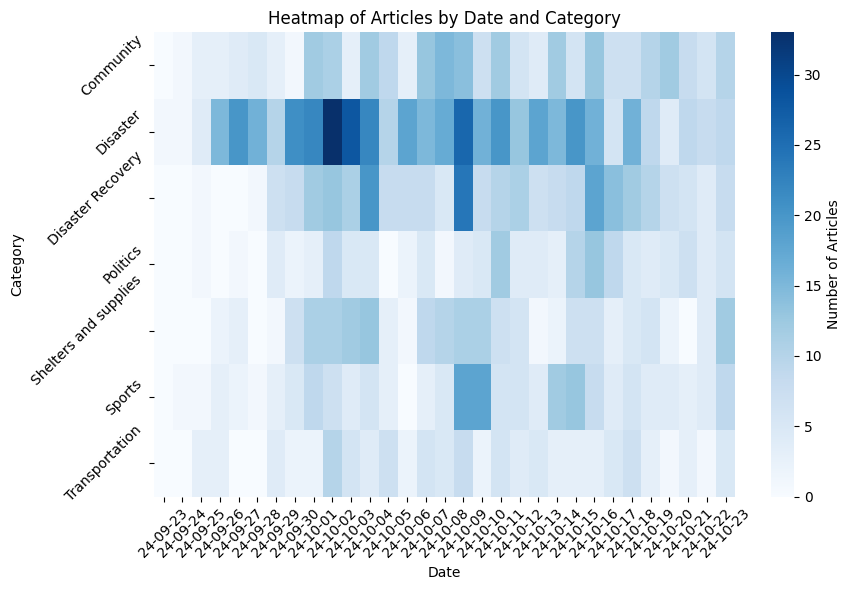

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

heatmap_data = articles_label_topic_1.groupby(['date', 'Category']).size().unstack(fill_value=0)
# heatmap_data['date'] = heatmap_data['date'].dt.strftime('%m-%d')  # Convert to month-day format

# Step 2: Plot heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(heatmap_data.T, cmap="Blues", annot=False, cbar_kws={'label': 'Number of Articles'})
plt.title("Heatmap of Articles by Date and Category")
plt.xlabel("Date")
plt.ylabel("Category")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
df_count = labels.groupby("Category")['Name'].count().reset_index().sort_values("Name")
df_count

,Category,Name
6,Transportation,113
3,Politics,133
4,Shelters and supplies,167
5,Sports,172
0,Community,232
2,Disaster Recovery,258
1,Disaster,458


In [ ]:
df_count = labels.groupby("Category")['Name'].count().reset_index().sort_values("article")

plt.bar(df_count['information'], df_count['article'])
plt.title("Articles with Practical Information by Categories")
plt.xlabel("Categories")
plt.ylabel("Number of Articles (in total)")
plt.xticks(rotation=30)
# plt.legend(title="Information Category", bbox_to_anchor=(1.05, 1), loc='upper left')
# for p in ax.patches: ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.tight_layout()
plt.show()

#### Method 2: Keywords extraction + topic modeling

Get sentence keywords with BERT transformer

In [68]:
from keybert import KeyBERT

# Load the KeyBERT model
model = KeyBERT()

# Extract keywords from an article
keywords = model.extract_keywords(sub_articles['cleaned_text'][3], keyphrase_ngram_range=(1, 2), stop_words='english')

print(keywords)

[('blue ridge', 0.4526), ('energy crews', 0.4525), ('supporting restoration', 0.4268), ('neighborhoods crews', 0.4056), ('power service', 0.3989)]


In [47]:
# Extract keywords from an article
keywords = model.extract_keywords(" ".join(sub_articles['stemmed_tokens'][3]), keyphrase_ngram_range=(1, 2), stop_words='english')

print(keywords)

[('rebuilt saw', 0.6123), ('technician consist', 0.5595), ('technician', 0.5317), ('saw', 0.4373), ('rebuilt', 0.4124)]


In [69]:
# FUNC: Extract keywords from an article
def get_keywords(text):
    kws = model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english')
    keywords.extend([kw[0] for kw in kws]) 

In [70]:
# Extract keywords from all articles' clean text
# Store keywords of each article into one list
keywords = []
sub_articles['cleaned_text'].apply(get_keywords)

0       None
1       None
2       None
3       None
12      None
        ... 
1906    None
1907    None
1908    None
1909    None
1910    None
Name: cleaned_text, Length: 1679, dtype: object

Using k-mean to unsupervised clustering keyword vectors, that allows us to dynamically discover categories

In [71]:
from sklearn.cluster import KMeans
import numpy as np
from sentence_transformers import SentenceTransformer

# Load a pre-trained Sentence-BERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the keywords into vectors
keyword_embeddings = sbert_model.encode(keywords)

Optimal number of clusters: 49


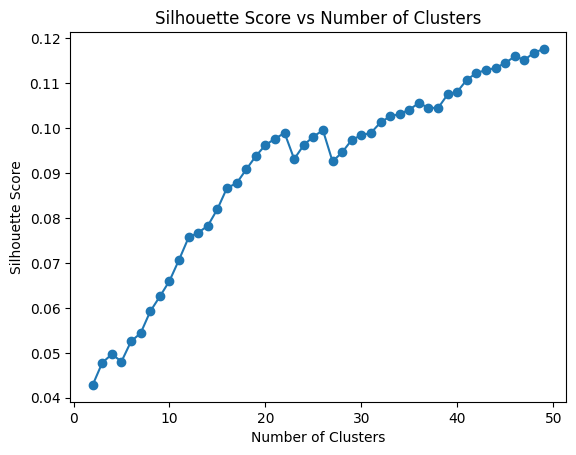

In [73]:
# Choose the optimal number of categories
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Sample embeddings (replace this with your keyword embeddings)
# keyword_embeddings = ...

# Range of cluster numbers to test
range_n_clusters = range(2, 50)  # Test from 2 to 10 clusters
silhouette_scores = []

for n_clusters in range_n_clusters:
    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(keyword_embeddings)
    
    # Calculate silhouette score
    score = silhouette_score(keyword_embeddings, cluster_labels)
    silhouette_scores.append(score)

# Find the optimal number of clusters
optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")

# Optional: Plot silhouette scores to visualize
import matplotlib.pyplot as plt
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

Silhouette scores have been really low, which indicates that there is probably no natural clustering. This makes sense as these keywords might be very concentrated on "hurricane" related topic.

In [74]:
# Encode keywords
# keyword_embeddings = model.encode(keywords)

# Apply KMeans clustering
num_categories = 45  # Adjust based on your need
kmeans = KMeans(n_clusters=num_categories, random_state=42).fit(keyword_embeddings)

# Print clustered categories
for cluster in range(num_categories):
    cluster_keywords = [keywords[i] for i in range(len(keywords)) if kmeans.labels_[i] == cluster]
    print(f"Cluster {cluster}: {cluster_keywords}")

Cluster 0: ['neighborhoods crews', 'swannanoa resident', 'mills tennessee', 'mills tenn', 'area gastonia', 'gastonia police', 'colletsville community', 'colletsville nc', 'community colletsville', 'efforts colletsville', 'colletsville', 'town forest', 'center waynesville', 'waynesville center', 'waynesville', 'center waynesville', 'waynesville center', 'waynesville', 'road waynesville', 'canton town', 'citycade looking', 'clyde residents', 'bakersville helen', 'city zachary', 'jefferson florence', 'town council', 'town dentist', 'town forest', 'dentist town', 'library downtown', 'downtown marshall', 'smathers town', 'crest lincolnton', 'crest lincolnton', 'tryon residents', 'tryon town', 'downtown waynesville', 'coming waynesville', 'waynesville campaign', 'come waynesville', 'waynesville smoky', 'gastonia city', 'porvenir community', 'cooper village', 'leary village', 'emma communities', 'assessments waynesville', 'town minneapolis', 'happening barnardsville', 'neighbors davis', 'resi

Test probability clustering with kmeans

In [ ]:
probs.shape

(1679, 40)

In [44]:
from sklearn.cluster import KMeans

# Use topic probabilities as input for clustering
num_clusters = 10  # Choose the number of clusters you want
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(probs)

# Now each article is assigned to a cluster
print(cluster_labels)

[1 1 1 ... 1 1 1]


In [42]:
import pandas as pd

# Create a DataFrame
topic_labels = pd.DataFrame({
    'article': sub_articles['cleaned_text'],
    'topic': topics,
    'cluster': cluster_labels
})

print(topic_labels.head())


                                              article  topic  cluster
0   boone samaritan s purse and alliance bible fel...     14        1
1   attorney general josh stein declared the state...     -1        1
2   widespread power outages due to damage from hu...     -1        1
3   more than 300 line technicians consisting of b...      4        1
12  university of virginia recruit and a c reynold...      0        1


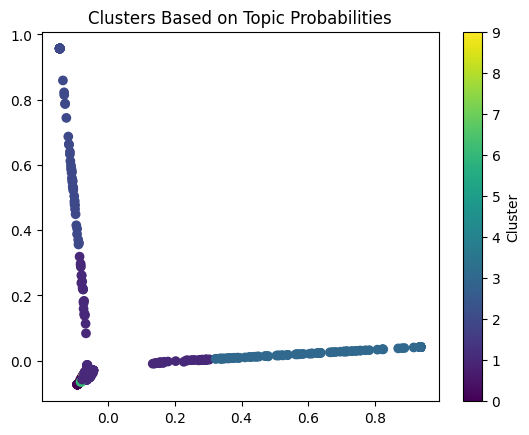

In [45]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_probs = pca.fit_transform(probs)

plt.scatter(reduced_probs[:, 0], reduced_probs[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(label="Cluster")
plt.title("Clusters Based on Topic Probabilities")
plt.show()

### Geographical Mapping

Of newspaper publications & of coverage

In [3]:
# Get a subset of valid articles because we don't have all
sub_articles = articles[articles['word_count'] != '']

# Import geojson data
us_counties = gpd.read_file("https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json")
nc_counties = us_counties[us_counties['STATE'] == '37']     # NC only


In [4]:
# Load the pre-trained spaCy model
nlp = spacy.load('en_core_web_sm')
text = articles['cleaned_article'][0]

# FUNC: find location entity using NER
# Return (List) of locations in text
def ner_location(text):
    doc = nlp(text)
    loc = []
    for ent in doc.ents:
        if ent.label_ == "GPE":  # GPE = Geopolitical Entity
            loc.append(ent.text)
            # print(f"Location identified: {ent.text}")
    return loc

In [5]:
# FUNC: detect if text contains county in c_list
# if so, +1 to the value of that county in c_dict
def detect_place(text, c_list, c_dict):
    if text == "":
        return
    locations = ner_location(text)
    for loc in locations:
        loc = loc.lower().replace(' county','')
        if loc in c_list:
            if loc in c_dict.keys():
                c_dict[loc] +=1
            else:
                c_dict[loc] = 1

#### Publication by county

In [62]:
# Article publication by county
counties = sub_articles.groupby('County')['article'].count().reset_index()

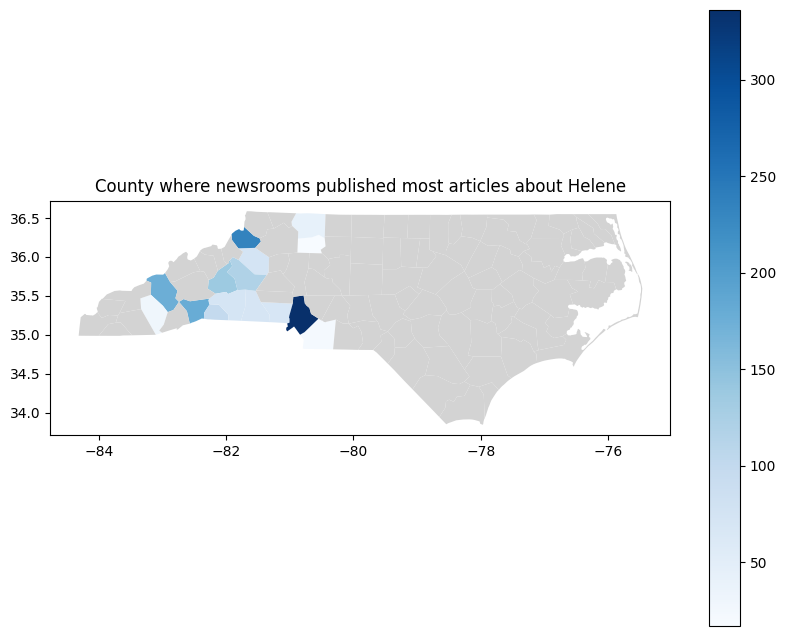

In [14]:
merged = nc_counties.merge(counties, left_on='NAME', right_on='County', how='left')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged.plot(column='article', ax=ax, legend=True, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"})
plt.title("County where newsrooms published most articles about Helene")
plt.show()

#### Coverage by County

In [20]:
# Get coverage by county
county_list = nc_counties.NAME.str.lower().reset_index().NAME.to_list()
# county_list = nc_counties.NAME.to_list()
county_dict = {}
sub_articles['cleaned_article'].apply(lambda x: detect_place(x, county_list, county_dict))
c_df = pd.DataFrame(list(county_dict.items()), columns=['County', 'coverage'])

# Merge
nc_counties['NAME_2'] = nc_counties['NAME'].str.lower()
merged = nc_counties.merge(c_df, left_on='NAME_2', right_on='County', how='left')

/Users/yanans/Desktop/helene_coverage/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [23]:
c_df.sort_values('coverage',ascending=False)

,County,coverage
19,haywood,330
6,buncombe,223
8,mcdowell,210
0,watauga,200
9,henderson,195
...,...,...
59,chatham,1
60,anson,1
26,orange,1
11,pender,1


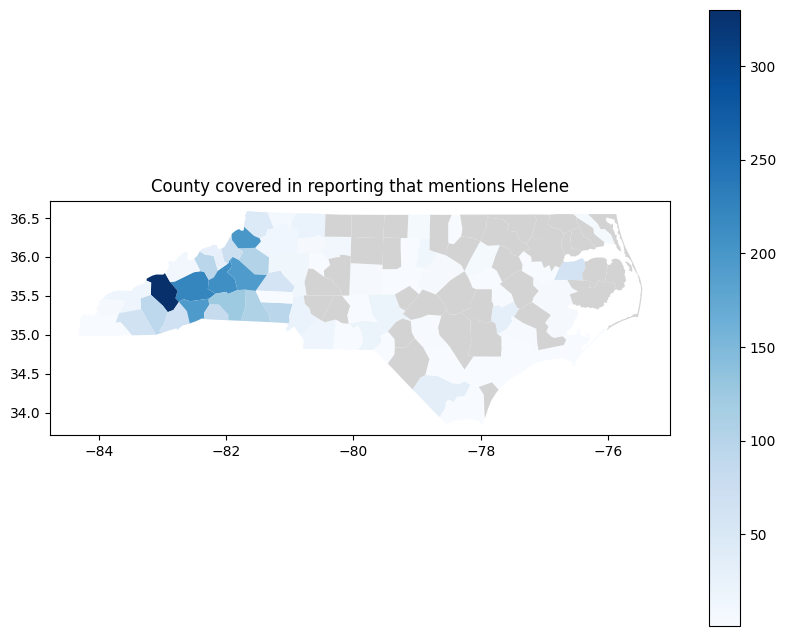

In [22]:
# Make choropleth
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged.plot(column='coverage', ax=ax, legend=True, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"})
plt.title("County covered in reporting that mentions Helene")
plt.show()

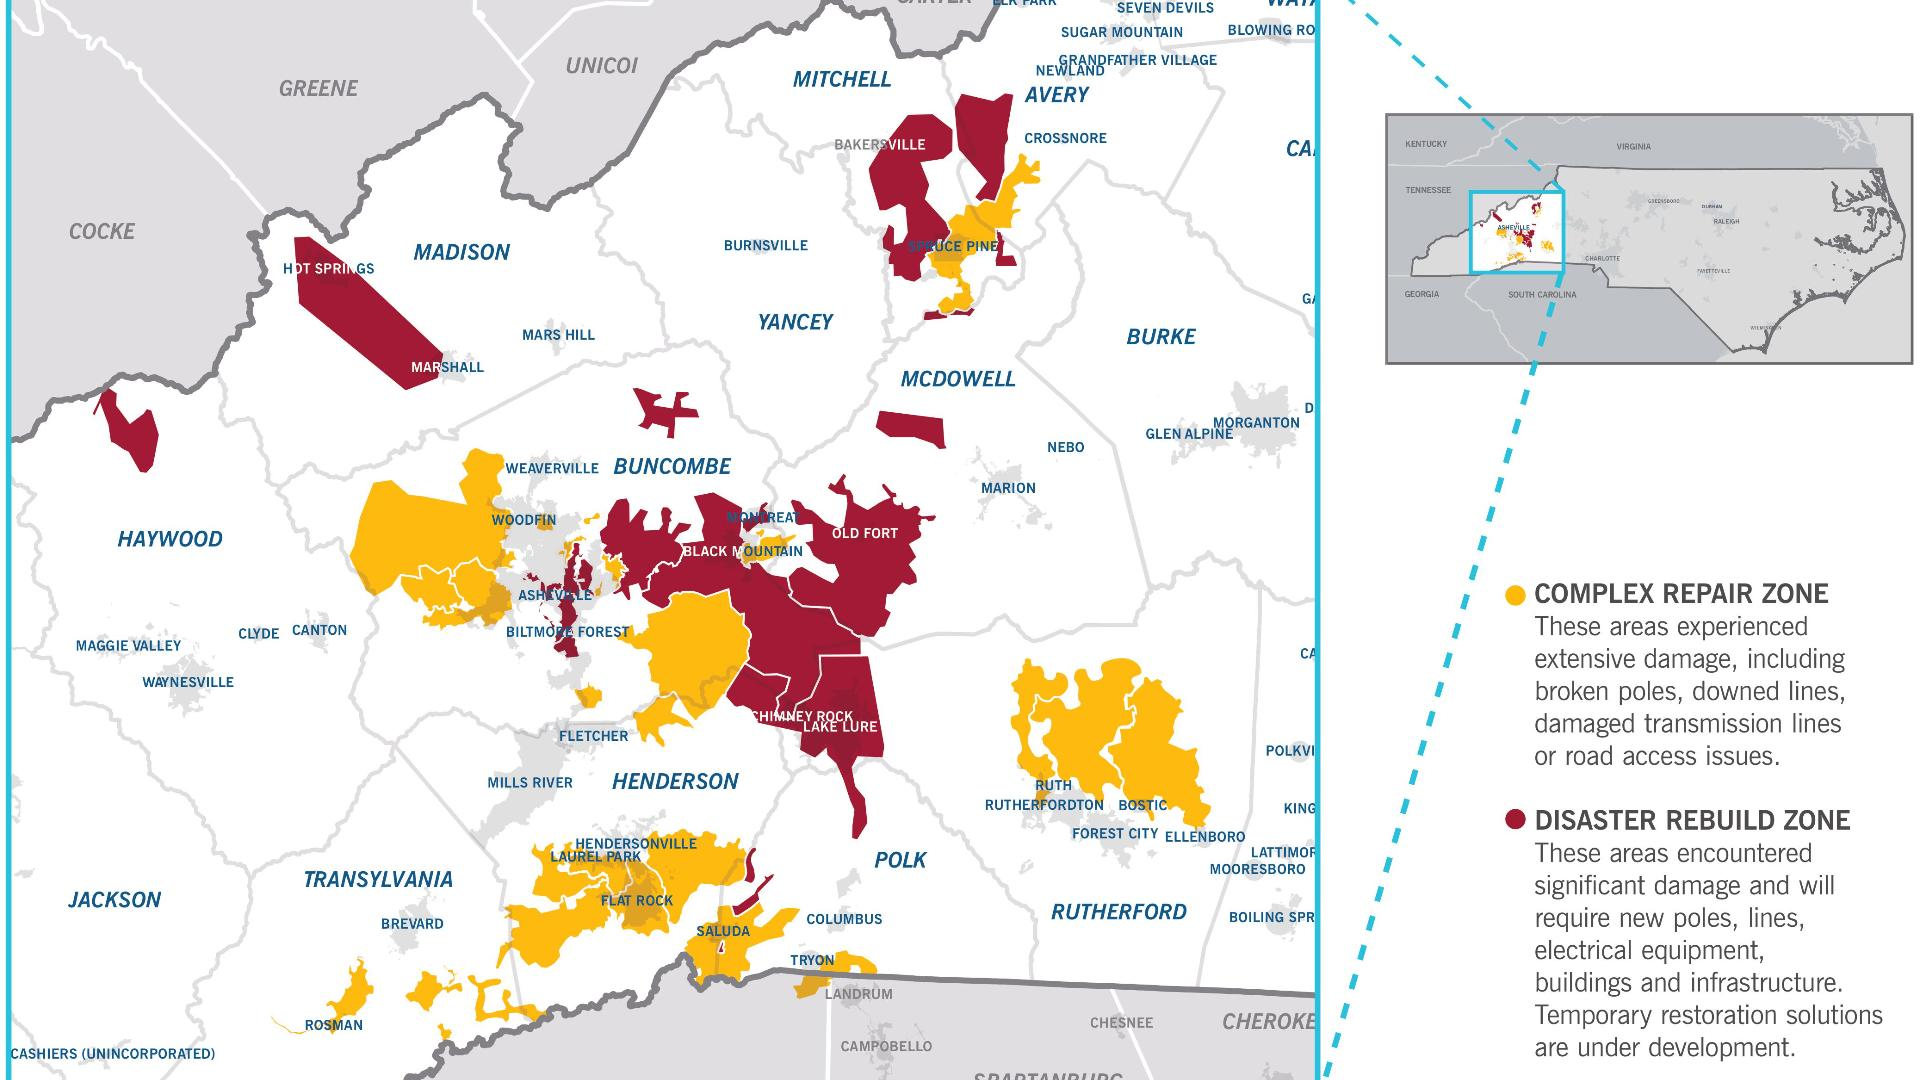

#### County publication breakdown by date

In [27]:
county_time = sub_articles.groupby(['County','date'])['article'].count().reset_index()
county_time.head()

,County,date,article
0,Burke,2024-09-25,1
1,Burke,2024-09-26,1
2,Burke,2024-09-27,1
3,Burke,2024-09-29,1
4,Burke,2024-09-30,3


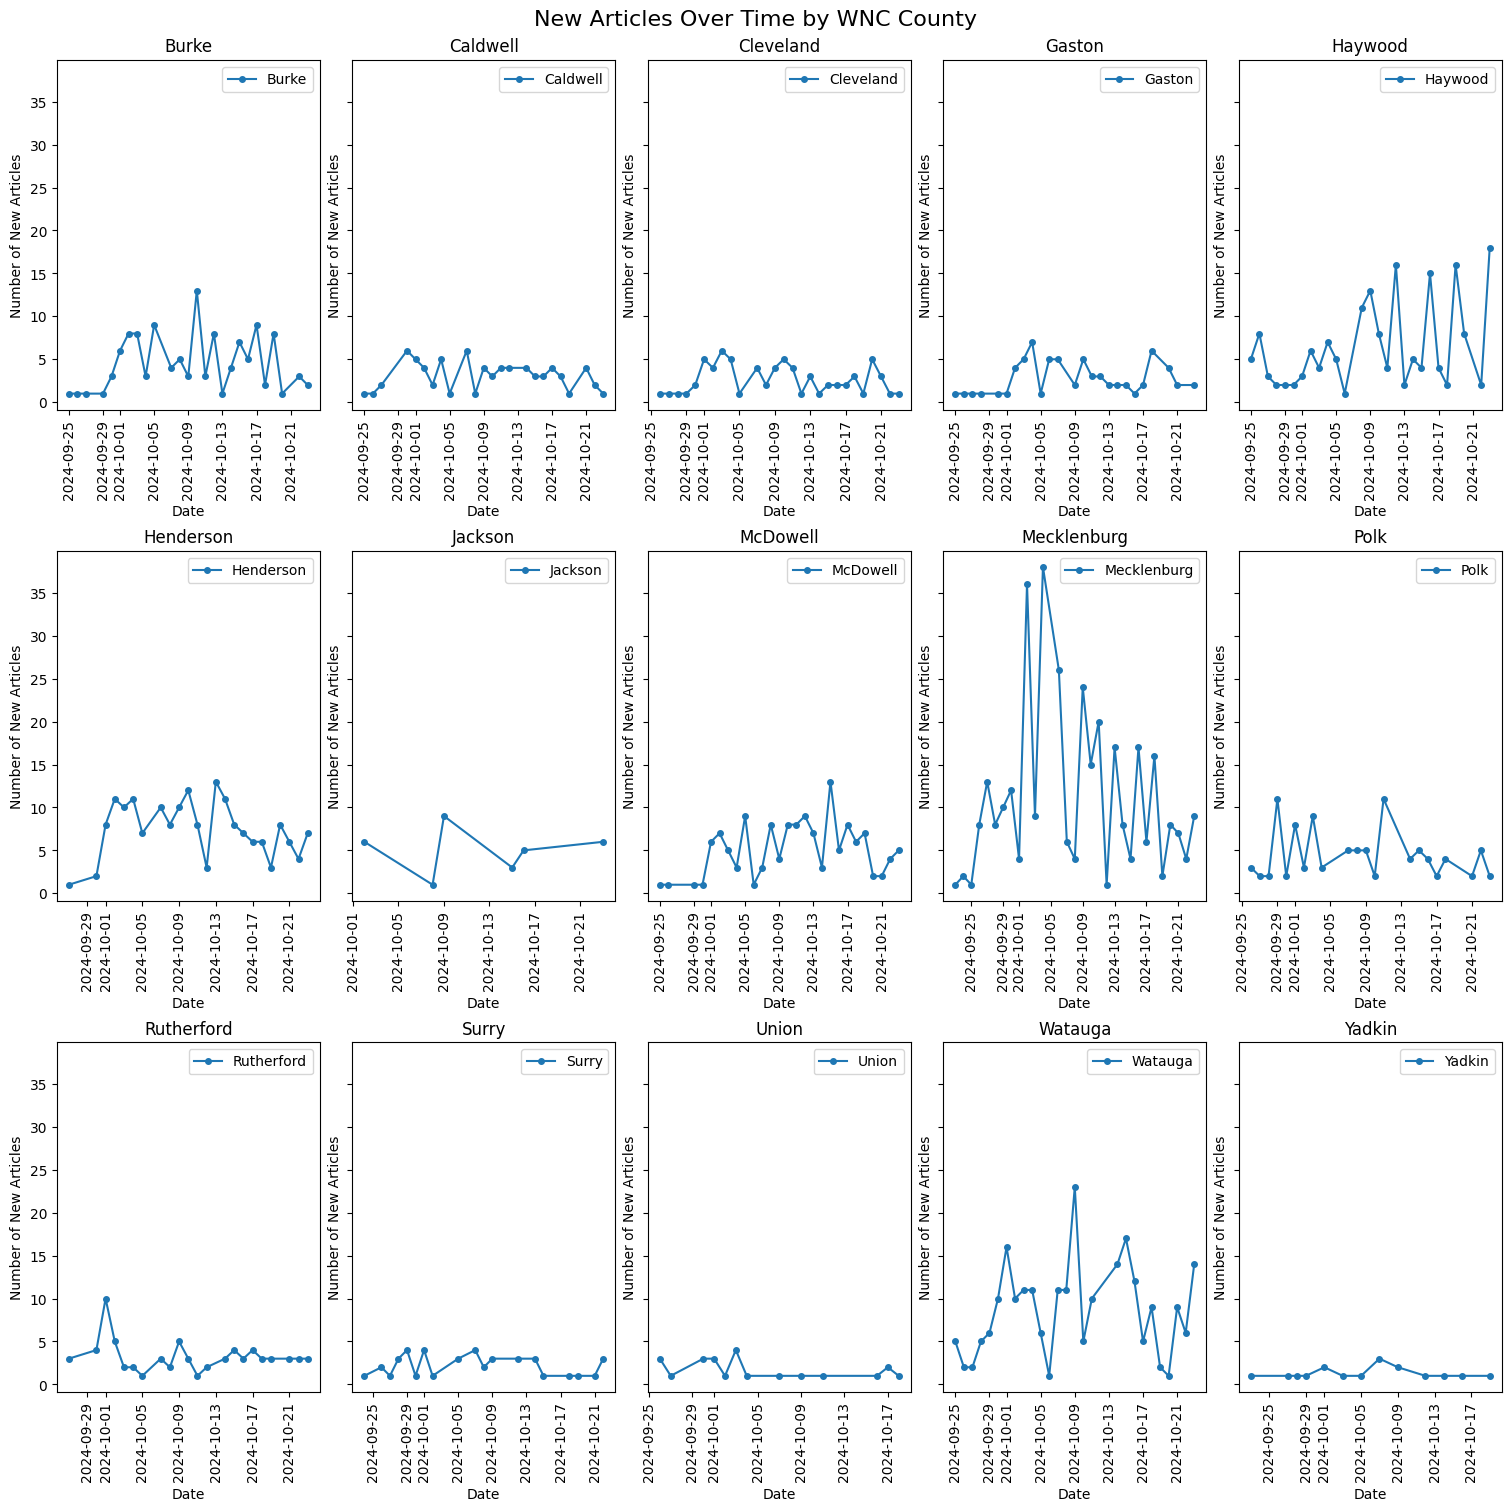

In [28]:
# Group by county
counties = county_time['County'].unique()
n_counties = len(counties)

# Create small multiples
cols = 5  # Number of columns in the grid
rows = (n_counties + cols - 1) // cols  # Calculate rows needed
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), constrained_layout=True, sharey=True)

# Flatten axes for easy indexing (in case rows * cols > n_counties)
axes = axes.flatten()

# Plot data for each county
for i, county in enumerate(counties):
    ax = axes[i]
    county_data = county_time[county_time['County'] == county]
    ax.plot(county_data['date'], county_data['article'], marker='o', markersize = 4, label=county)
    ax.set_title(county)
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of New Articles")
    ax.tick_params(axis='x', rotation=90)
    ax.legend()

# Remove unused subplots if the number of counties is less than rows * cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("New Articles Over Time by WNC County", fontsize=16)
plt.show()

#### County Coverage Breakdown by Time

In [29]:
beginning = sub_articles[sub_articles['date'] < '2024-10-08']
ending = sub_articles[sub_articles['date'] >= '2024-10-08']

/Users/yanans/Desktop/helene_coverage/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/cn/fww9r0gd1mg20td4q8v12_lsknvlj7/T/ipykernel_31312/639751775.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


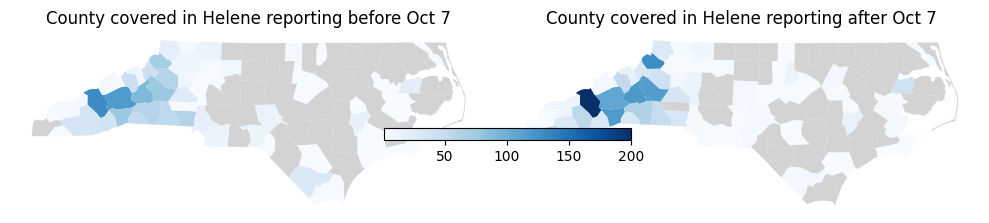

In [30]:
# Get coverage by county
county_list = nc_counties.NAME.str.lower().reset_index().NAME.to_list()
begin, end = {},{}
beginning['cleaned_article'].apply(lambda x: detect_place(x, county_list, begin))
ending['cleaned_article'].apply(lambda x: detect_place(x, county_list, end))
c_df = pd.DataFrame(list(begin.items()), columns=['County', 'coverage'])
c_df_2 = pd.DataFrame(list(end.items()), columns=['County', 'coverage'])

# Merge
nc_counties['NAME_2'] = nc_counties['NAME'].str.lower()
merged = nc_counties.merge(c_df, left_on='NAME_2', right_on='County', how='left')
merged_2 = nc_counties.merge(c_df_2, left_on='NAME_2', right_on='County', how='left')

# Make choropleth
# Determine global color limits
vmin = min(merged['coverage'].min(), merged_2['coverage'].min())
vmax = max(merged['coverage'].max(), merged_2['coverage'].max())

fig, axes = plt.subplots(1, 2, figsize=(10, 8))
merged.plot(column='coverage', ax=axes[0], legend=False, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"}, vmin=vmin, vmax=vmax)
axes[0].set_title("County covered in Helene reporting before Oct 7")
axes[0].axis('off')

merged_2.plot(column='coverage', ax=axes[1], legend=False, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"}, vmin=vmin, vmax=vmax)
axes[1].set_title("County covered in Helene reporting after Oct 7")
axes[1].axis('off')

# Add a shared colorbar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Required for ScalarMappable with no data
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.02, pad=0)

plt.tight_layout()

# plt.title("County covered in reporting that mentions Helene before and after Oct 7")
plt.show()

Week by week?

In [31]:
one = sub_articles[sub_articles['date'] < '2024-09-30']
two = sub_articles[(sub_articles['date'] >= '2024-09-30') & (sub_articles['date'] <= '2024-10-07')]
three = sub_articles[(sub_articles['date'] > '2024-10-07') & (sub_articles['date'] <= '2024-10-15')]
four = sub_articles[(sub_articles['date'] > '2024-10-15') & (sub_articles['date'] <= '2024-10-23')]

/var/folders/cn/fww9r0gd1mg20td4q8v12_lsknvlj7/T/ipykernel_31312/2429238123.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(h_pad=0.5)


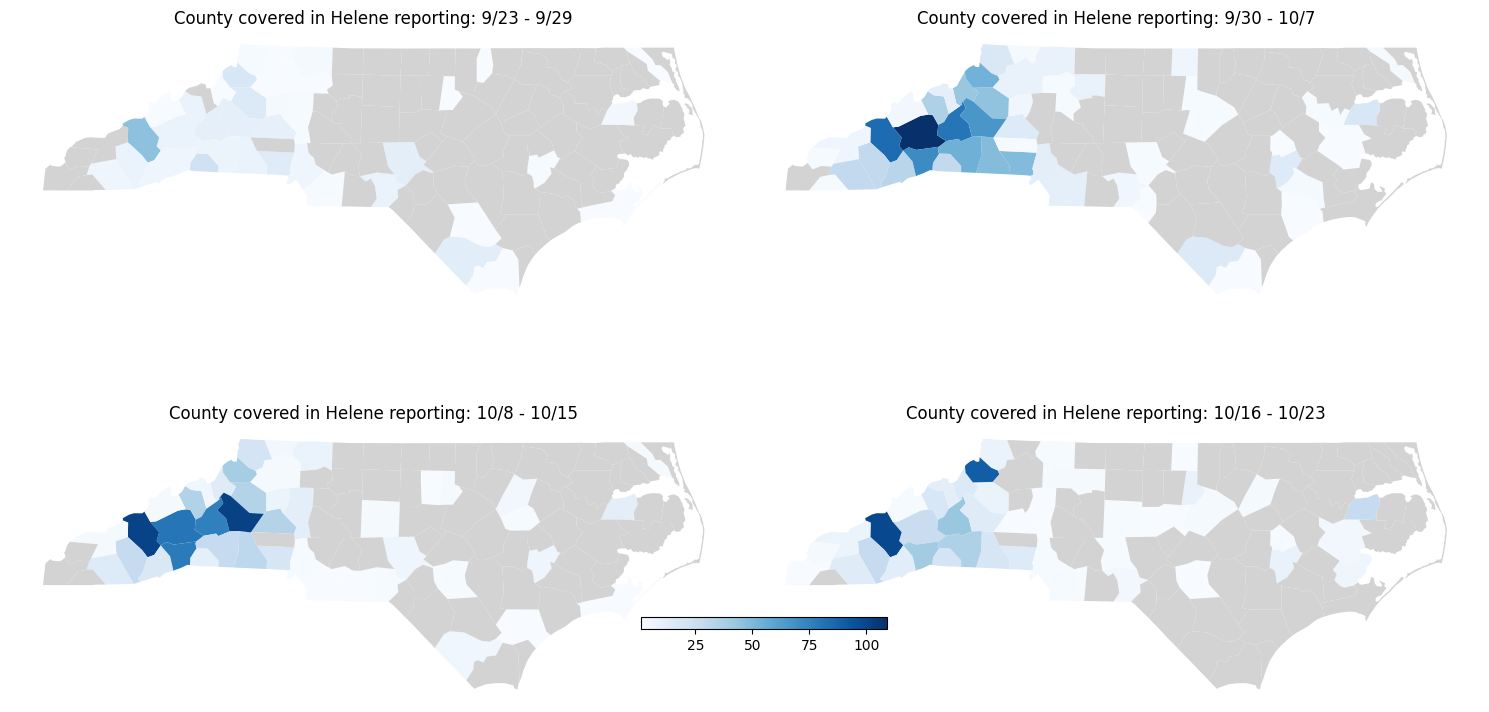

In [ ]:
# Get coverage by county
county_list = nc_counties.NAME.str.lower().reset_index().NAME.to_list()
week1, week2, week3, week4 = {},{},{},{}
one['cleaned_article'].apply(lambda x: detect_place(x, county_list, week1))
two['cleaned_article'].apply(lambda x: detect_place(x, county_list, week2))
three['cleaned_article'].apply(lambda x: detect_place(x, county_list, week3))
four['cleaned_article'].apply(lambda x: detect_place(x, county_list, week4))

c_df = pd.DataFrame(list(week1.items()), columns=['County', 'coverage'])
c_df_2 = pd.DataFrame(list(week2.items()), columns=['County', 'coverage'])
c_df_3 = pd.DataFrame(list(week3.items()), columns=['County', 'coverage'])
c_df_4 = pd.DataFrame(list(week4.items()), columns=['County', 'coverage'])

# Merge
nc_counties['NAME_2'] = nc_counties['NAME'].str.lower()
merged = nc_counties.merge(c_df, left_on='NAME_2', right_on='County', how='left')
merged_2 = nc_counties.merge(c_df_2, left_on='NAME_2', right_on='County', how='left')
merged_3 = nc_counties.merge(c_df_3, left_on='NAME_2', right_on='County', how='left')
merged_4 = nc_counties.merge(c_df_4, left_on='NAME_2', right_on='County', how='left')

# Make choropleth
# Determine global color limits
vmin = min(merged['coverage'].min(), merged_2['coverage'].min(), merged_3['coverage'].min(), merged_4['coverage'].min())
vmax = max(merged['coverage'].max(), merged_2['coverage'].max(), merged_3['coverage'].max(), merged_4['coverage'].max())

fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Flatten the axes for easy access
axes = axes.flatten()

merged.plot(column='coverage', ax=axes[0], legend=False, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"}, vmin=vmin, vmax=vmax)
axes[0].set_title("County covered in Helene reporting: 9/23 - 9/29")
axes[0].axis('off')

merged_2.plot(column='coverage', ax=axes[1], legend=False, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"}, vmin=vmin, vmax=vmax)
axes[1].set_title("County covered in Helene reporting: 9/30 - 10/7")
axes[1].axis('off')

merged_3.plot(column='coverage', ax=axes[2], legend=False, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"}, vmin=vmin, vmax=vmax)
axes[2].set_title("County covered in Helene reporting: 10/8 - 10/15")
axes[2].axis('off')

merged_4.plot(column='coverage', ax=axes[3], legend=False, cmap='Blues', missing_kwds={"color": "lightgrey", "label": "No data"}, vmin=vmin, vmax=vmax)
axes[3].set_title("County covered in Helene reporting: 10/16 - 10/23")
axes[3].axis('off')

# Add a shared colorbar
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Required for ScalarMappable with no data
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.02, pad=0.2)

fig.tight_layout(h_pad=0.5)
# plt.title("County covered in reporting that mentions Helene before and after Oct 7")
plt.show()

### Sentiment Analysis

In [102]:
from textblob import TextBlob

def analyze_sentiment(text):
    sentiment = TextBlob(text).sentiment
    return sentiment.polarity

In [104]:
analyze_sentiment(articles['article_text'][0])

0.12356837606837609

In [105]:
sub_articles['polarity'] = sub_articles['article_text'].apply(analyze_sentiment)

In [109]:
def analyze_subjectivity(text):
    sentiment = TextBlob(text).sentiment
    return sentiment.subjectivity

In [110]:
sub_articles['subjectivity'] = sub_articles['article_text'].apply(analyze_subjectivity)

In [75]:
from nrclex import NRCLex

def analyze_emotion(text):
    emotion = NRCLex(text)
    return emotion.raw_emotion_scores

In [77]:
sub_articles['emotions'] = sub_articles['article_text'].apply(analyze_emotion)

Emotion list: fear
anger
anticipation
trust
surprise
positive
negative
sadness
disgust
joy

For each emotion, get its min, max, and median

##### Polarity

In [106]:
sub_articles.groupby('date').mean("polarity")

,polarity
date,
2024-09-23,0.004771
2024-09-24,0.040657
2024-09-25,0.061045
2024-09-26,0.053384
2024-09-27,0.035950
2024-09-28,0.082791
2024-09-29,0.059836
2024-09-30,0.078251
2024-10-01,0.079953


In [111]:
sub_articles.groupby('date').mean("subjectivity")

,polarity,subjectivity
date,,
2024-09-23,0.004771,0.422230
2024-09-24,0.040657,0.442280
2024-09-25,0.061045,0.434332
2024-09-26,0.053384,0.410509
2024-09-27,0.035950,0.370643
2024-09-28,0.082791,0.363957
2024-09-29,0.059836,0.362480
2024-09-30,0.078251,0.372332
2024-10-01,0.079953,0.396699


In [94]:
sub_articles.head()

,header,article,title,date,newspaper,author,word_count,County,Outlet,article_text,cleaned_text,tokens,stemmed_tokens,emotions,polarity
0,"Samaritan’s Purse, Alliance Bible Fellowship e...",BOONE — Samaritan's Purse and Alliance Bible F...,"Samaritan’s Purse, Alliance Bible Fellowship e...",2024-10-02,Watauga Democrat,Luke Barber luke.barber@wataugademocrat.com,593.0,Watauga,Watauga Democrat,BOONE — Samaritan's Purse and Alliance Bible F...,boone samaritan s purse and alliance bible fel...,"[boone, samaritan, purse, fellowship, 1035, hw...","[boon, samaritan, purs, fellowship, 1035, hwi,...","{'trust': 29, 'anger': 7, 'disgust': 5, 'fear'...","(0.12356837606837609, 0.353034188034188)"
1,Watch out for scammers as recovery efforts mov...,Attorney General Josh Stein declared the state...,Watch out for scammers as recovery efforts mov...,2024-10-02,Watauga Democrat,Ben McNeely,379.0,Watauga,Watauga Democrat,Attorney General Josh Stein declared the state...,attorney general josh stein declared the state...,"[stein, gouging, landfall, activated, declares...","[stein, goug, landfal, activ, declar, unreason...","{'trust': 16, 'positive': 20, 'fear': 12, 'neg...","(0.059920634920634916, 0.46970899470899463)"
2,STORM RECOVERY: Carbon Monoxide Safety\nOctobe...,Widespread power outages due to damage from Hu...,STORM RECOVERY: Carbon Monoxide Safety,2024-10-02,Watauga Democrat,Staff Writer,440.0,Watauga,Watauga Democrat,Widespread power outages due to damage from Hu...,widespread power outages due to damage from hu...,"[outages, boone, monoxide, poisoning, applianc...","[outag, boon, monoxid, poison, applianc, gener...","{'anger': 8, 'disgust': 11, 'negative': 22, 's...","(0.08785714285714286, 0.4471596921596923)"
3,Outage restoration continues with more than 40...,More than 300 line technicians consisting of B...,Outage restoration continues with more than 40...,2024-10-02,Watauga Democrat,Moss Brennan moss.brennan@wataugademocrat.com,267.0,Watauga,Watauga Democrat,More than 300 line technicians consisting of B...,more than 300 line technicians consisting of b...,"[technicians, consisting, cooperatives, gradin...","[technician, consist, cooper, grade, categor, ...","{'anger': 4, 'anticipation': 7, 'disgust': 2, ...","(0.10844444444444445, 0.38888888888888895)"
12,Virginia commit Hamrick returning to Crest Hig...,University of Virginia recruit and A.C. Reynol...,Virginia commit Hamrick returning to Crest Hig...,2024-10-10,Gaston Gazette,Joe L Hughes II; Shelby Star,344.0,Gaston,The Gaston Gazette,University of Virginia recruit and A.C. Reynol...,university of virginia recruit and a c reynold...,"[ely, hamrick, crest, crest, crest, asheville,...","[eli, hamrick, crest, crest, crest, ashevil, b...","{'positive': 9, 'trust': 12, 'anticipation': 7...","(0.13415584415584417, 0.37831709956709964)"


##### Emotions

In [78]:
sub_articles['emotions'][0].keys()

dict_keys(['trust', 'anger', 'disgust', 'fear', 'negative', 'sadness', 'surprise', 'anticipation', 'joy', 'positive'])

In [79]:
e_list = ["fear","anger","anticipation","trust","surprise","positive","negative","sadness","disgust","joy"]

def compute_overall_emotions(emotions, mini, maxi, eSum, eCount):
    for emo in emotions.keys():
        loc = e_list.index(emo)
        mini[loc] = min(mini[loc], emotions[emo])
        maxi[loc] = max(maxi[loc], emotions[emo])
        eSum[loc] += emotions[emo]
        eCount[loc] +=1
    # for i in range(10):
    #     eMedian[i] = eSum[i] / eCount[i]
    # emotions_df['mediam'] = emotions_df['sum'] / emotions_df['count']


def compute_df_emotions(df):
    mini, maxi, eSum, eCount, eMedian = [100] *10, [0]*10,[0]*10, [0]*10, [0] * 10
    for index, row in df.iterrows():
        compute_overall_emotions(row['emotions'], mini, maxi, eSum, eCount)
    emotions_df = pd.DataFrame({'emotion': e_list,
                                'minimum': mini,
                                'maximum':maxi, 
                                'sum': eSum, 
                                'count': eCount})
    emotions_df['median'] = emotions_df['sum'] / emotions_df['count']
    return emotions_df


In [80]:
total_emo = compute_df_emotions(sub_articles)
total_emo

,emotion,minimum,maximum,sum,count,median
0,fear,1,95,14992,1568,9.561224
1,anger,1,78,13243,1560,8.489103
2,anticipation,1,144,20168,1609,12.534493
3,trust,1,280,28194,1624,17.360837
4,surprise,1,54,8889,1469,6.051055
5,positive,1,359,46318,1644,28.173966
6,negative,1,172,26434,1623,16.287123
7,sadness,1,88,13996,1582,8.847029
8,disgust,1,45,7678,1426,5.384292
9,joy,1,97,14117,1529,9.232832


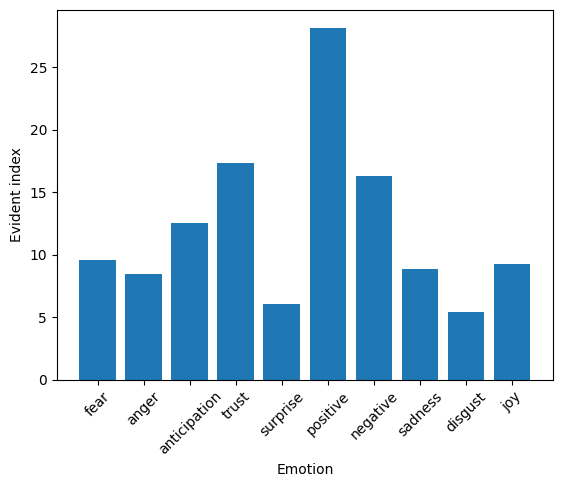

In [81]:
# Plotting the data
plt.bar(total_emo['emotion'], total_emo['median'])
plt.xlabel('Emotion')
plt.ylabel('Evident index')
plt.xticks(rotation=45)

# plt.title('')
plt.show()

In [82]:
# Week by week
one = sub_articles[sub_articles['date'] < '2024-09-30']
two = sub_articles[(sub_articles['date'] >= '2024-09-30') & (sub_articles['date'] <= '2024-10-07')]
three = sub_articles[(sub_articles['date'] > '2024-10-07') & (sub_articles['date'] <= '2024-10-15')]
four = sub_articles[(sub_articles['date'] > '2024-10-15') & (sub_articles['date'] <= '2024-10-23')]

In [83]:
# Compute emotions
one_emo = compute_df_emotions(one).sort_values('median')
two_emo = compute_df_emotions(two).sort_values('median')
three_emo = compute_df_emotions(three).sort_values('median')
four_emo = compute_df_emotions(four).sort_values('median')

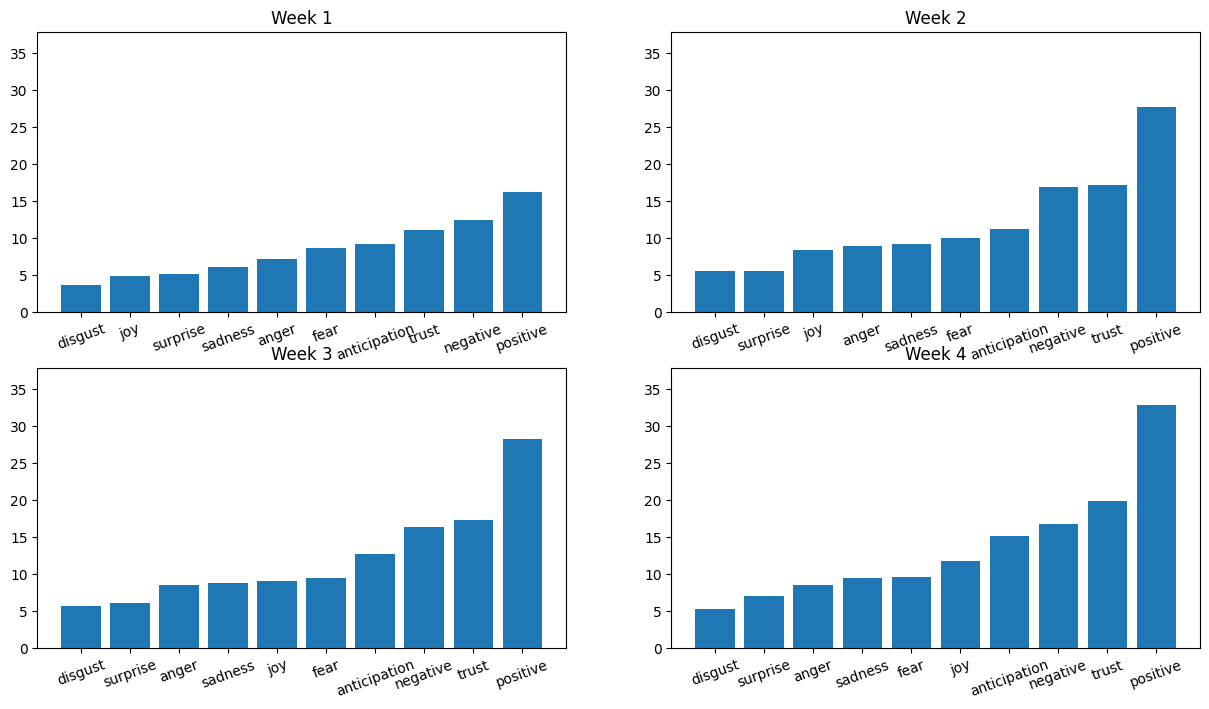

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# First bar plot
axes[0, 0].bar(one_emo['emotion'], one_emo['median'])
axes[0, 0].set_title('Week 1')

# Second bar plot
axes[0, 1].bar(two_emo['emotion'], two_emo['median'])
axes[0, 1].set_title('Week 2')

# Third bar plot
axes[1, 0].bar(three_emo['emotion'], three_emo['median'])
axes[1, 0].set_title('Week 3')

# Fourth bar plot
axes[1, 1].bar(four_emo['emotion'], four_emo['median'])
axes[1, 1].set_title('Week 4')

# Determine the common limits
x_min = min(one_emo['median'].min(), two_emo['median'].min(), three_emo['median'].min(), four_emo['median'].min())
x_max = max(one_emo['median'].max(), two_emo['median'].max(), three_emo['median'].max(), four_emo['median'].max())
# y_max = max(max(ax.patches[i].get_height() for i in range(len(ax.patches))) for ax in axes.ravel())

for ax in axes.flat:
    ax.tick_params(axis='x', rotation=20)
    # ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, x_max +5)


### Originality Detection

Detect whether articles are original

In [70]:
newspaper_list = ["Wall Street Journal", "USA Today","New York Times","Los Angeles Times", "Washington Post",
"Daily News",
"New York Post",
"San Jose Mercury News", "Chicago Tribune",
"Houston Chronicle",
"Philadelphia Inquirer",
"Newsday",
"Denver Post",
"Arizona Republic",
"Star Tribune",
"Dallas Morning News",
"Cleveland Plain Dealer","Seattle Times",
"Chicago Sun-Times",
"Detroit Free Press",
"Oregonian",
"San Diego Union-Tribune",
"San Francisco Chronicle",
"Star-Ledger",
"Boston Globe",
"St. Louis Post-Dispatch",
"Kansas City Star",
"Sacramento Bee",
"St. Paul Pioneer Press",
# Added based on what's in the database
"Associated Press",
"Winston-Salem Journal",
"USA TODAY",
"Gaston Gazette",
"Mount Airy News (mtairynews)",
'Hickory Daily Record (hickoryrecord)',
'Knoxville News Sentinel',
"Charlotte Observer",
"Daily Courier (thedigitalcourier)",
"Fayetteville Observer",
"WinstonSalem Journal",
"NorthJersey.com",
"Watauga Democrat (wataugademocrat)",
"Asheville Citizen Times",
"Shelby Star",
"Knoxville News Sentinel",
"Times-News",
"McDowell News (mcdowellnews)",
"Wilmington StarNews",
"News Herald (morganton)"   # based on data
]

In [76]:
import spacy
import regex

# FUNC: detect possible news organization through author tect
# with "organization" or "email" in author
def detect_possible_news_thr_author(author):
    for newspaper in newspaper_list:
        news = newspaper
        email = "email"
        if newspaper.find(" (") != -1:
            news = newspaper[:newspaper.find(" (")]
            email = newspaper[newspaper.find(" (")+2:-1]
        if news in author:
            return news
        if email in author:
            return newspaper[:newspaper.find(" (")]
    return ""

nlp = spacy.load("en_core_web_sm")

# FUNC: detect organizations in article texts
# return a list of organizations
def detect_organization(text):
    text = text.replace("\n", " \n").lower()
    doc = nlp(text)
    org_list = []
    for ent in doc.ents:
        if ent.label_ == "ORG":
            org_list.append(ent.text)
    return org_list

# FUNC: detect possible news organization from the list
# if these organization are in a new line and in newspaper list: 
# return that it might be a news organization
def detect_possible_news_through_ner(org_list):
    for org in org_list:
        if "\n" in org:
            for news in newspaper_list:
                if news.lower() in org.lower():
                    return news 
            # return "might be: " + org
    # return "original"
    return ""

Articles with the same title but published by different newspaper

In [87]:
import numpy as np

# detect possible news organization through author lines
articles['originality'] = articles['author'].apply(detect_possible_news_thr_author)
# if the original organization is the same as the "newspaper" column, the article is original
articles['originality'] = np.where(articles['newspaper'] == articles['originality'], 'original', articles['originality'])
len(articles[articles['originality'] != "original"])

1299

In [88]:
# Assume that those not detected are "original"
articles['originality'] = np.where(articles['originality'] == "", 'original', articles['originality'])
len(articles[articles['originality'] != "original"])

347

See if there's uncaptured duplicates based on same titles

In [89]:
# Filter all "original" articles
original = articles[articles['originality'] == "original"]

# in "original" articles, get titles with more than one newspaper values
duplicated_titles = original.groupby('title')['newspaper'].nunique()
titles_with_multiple_newspapers = duplicated_titles[duplicated_titles > 1].index

# Filter the rows with these titles
result = original[original['title'].isin(titles_with_multiple_newspapers)].sort_values("title")
len(result)

112

In [81]:
# Test min Levenshtein distance of same articles
# pip install python-Levenshtein
import Levenshtein

# except for 1154-488 where they seem to be the same but have different length
# text1 = result['cleaned_text'][1154]
# text2 = result['cleaned_text'][488]
text1 = result['cleaned_text'][1165]
text2 = result['cleaned_text'][558]
text3 = articles['cleaned_text'][864]
text4 = articles['cleaned_text'][878]

distance = Levenshtein.ratio(text1, text2)
print("Levenshtein Similarity:", distance)

Levenshtein Similarity: 0.8800095705227898


In [96]:
# FUNC: change past originality in databases
# also reset indexes and counts
def handle_past_originality(newspaper, indexes, counts):
    # print(indexes)
    newspaper = result["newspaper"][indexes[0]] if newspaper == "" else newspaper
    for index in indexes:
        # change in the original database
        articles.at[index, "originality"] = newspaper if articles["newspaper"][index] != newspaper else "original"

    # assign authors[0] to the 'originality' column for all indexes
    indexes.clear()
    counts.clear()
    return

In [97]:
# Assign "original" or "not original" to result
titles = []
indexes, counts, texts= [],[],[]
newspaper = ""
for index, row in result.iterrows():
    # No existing titles at the beginning
    # Add all information to lists
    title, count, author, org, text = row['title'], row['word_count'], row['author'], row['organization'], row['cleaned_text']
    if len(titles) == 0:
        titles.append(title)
        indexes.append(index)
        counts.append(count)
        texts.append(text)
        # find organization from author & texts:
        if detect_possible_news_thr_author(author) != "" or detect_possible_news_through_ner(org)!= "":
            newspaper = detect_possible_news_thr_author(author) if detect_possible_news_thr_author(author)!= "" else detect_possible_news_through_ner(org) 
    # After the first iteration:
    else:
        # Same title
        if title == titles[0]:
            # they are very similar artiles
            if abs(count-counts[-1]) <10 or Levenshtein.ratio(text, texts[-1]) > 0.88:
                # find organization from author & texts:
                if detect_possible_news_thr_author(author) != "" or detect_possible_news_through_ner(org)!= "":
                    newspaper = detect_possible_news_thr_author(author) if detect_possible_news_thr_author(author)!= "" else detect_possible_news_through_ner(org) 
                indexes.append(index)
                counts.append(count)
                texts.append(text)

        # New title or same title but different articles
        else:
            handle_past_originality(newspaper, indexes, counts)
            titles[0] = title
            indexes.append(index)
            counts.append(count)
            texts.append(text)
            newspaper = ""
            if detect_possible_news_thr_author(author) != "" or detect_possible_news_through_ner(org)!= "":
                newspaper = detect_possible_news_thr_author(author) if detect_possible_news_thr_author(author)!= "" else detect_possible_news_through_ner(org) 
# Handle last group:
handle_past_originality(newspaper, indexes, counts)

In [98]:
# Manually change the op-work to not original
articles.at[1154,"originality"] = "Not original"
articles.at[488,"originality"] = "Not original"

In [99]:
# Number of in-original work
len(articles[articles['originality']!="original"])

403

In [ ]:
# new_art = articles.drop(columns=['County', 'Outlet', 'cleaned_text',
#       'tokens', 'stemmed_tokens', 'information','organization', 'originality_group'])
# new_art.to_csv("graphics_data/helene_articles_originality_final", index=False)

#### Visualization

In [27]:
# articles = pd.read_csv("graphics_data/helene_articles_originality_final")

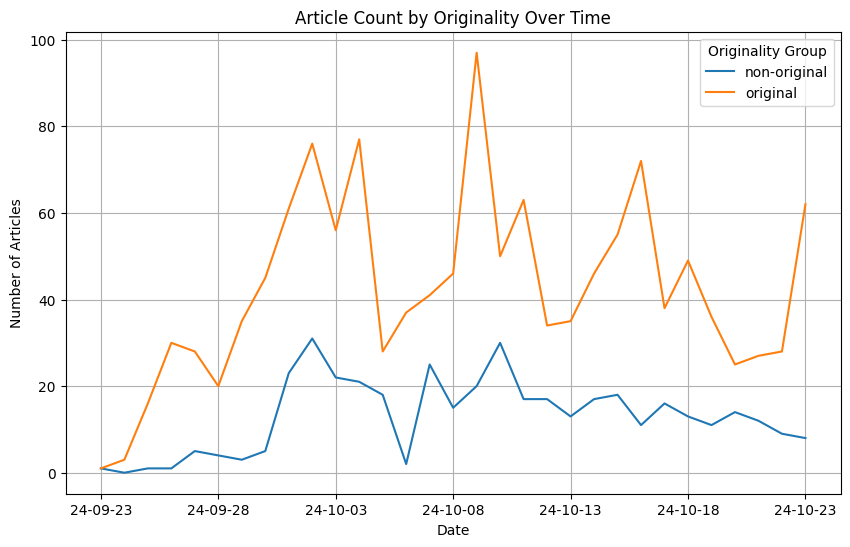

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a new column to classify into "original" and "non-original"
articles['originality_group'] = articles['originality'].apply(lambda x: 'original' if x == 'original' else 'non-original')

# Group by date and originality_group, then count the occurrences
grouped = articles.groupby(['date', 'originality_group']).size().reset_index(name='count')

# Pivot the table to make originality_group a separate column
pivoted = grouped.pivot(index='date', columns='originality_group', values='count').fillna(0)

# Plot the data
pivoted.plot(kind='line', figsize=(10, 6))
plt.title("Article Count by Originality Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.legend(title="Originality Group")
plt.grid(True)
plt.show()


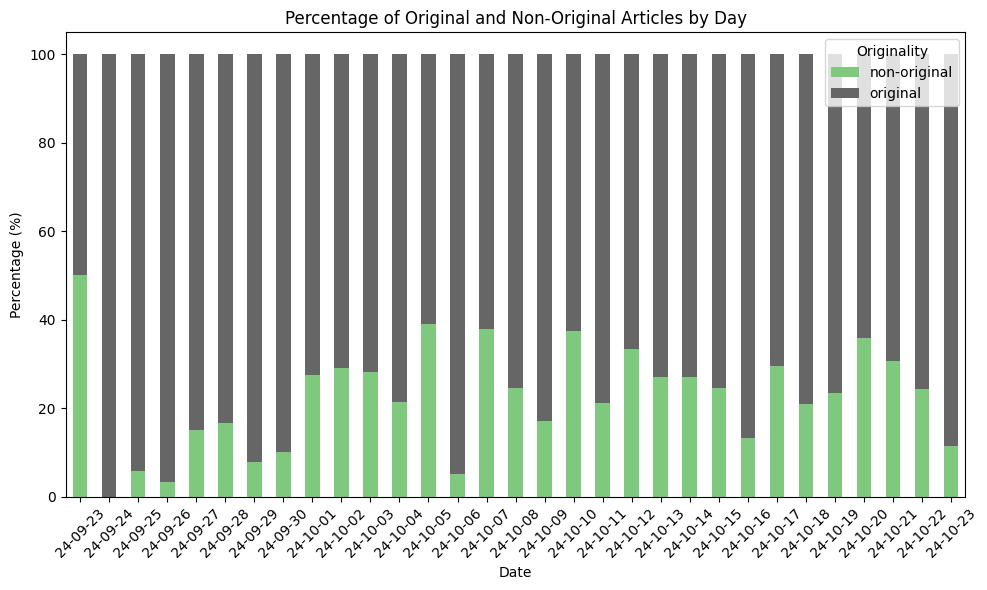

In [ ]:
# Calculate percentages
percentages = pivoted.div(pivoted.sum(axis=1), axis=0) * 100
# percentages.to_excel("graphics_data/originality_perc.xlsx", index=False)

# Plot
percentages.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Accent')

# Customize chart
plt.title('Percentage of Original and Non-Original Articles by Day')
plt.ylabel('Percentage (%)')
plt.xlabel('Date')
plt.legend(title='Originality')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Practical Information

To look at what practical information is given to people.

According to the <a href = 'https://app.adpc.net/?jet_download=16727'>"Disaster Reporting Handbook"</a> by Asian Preparedness Partnership, there are a few possible functions of mass media in four stages of disaster:

<img src = "disaster_reporting_handbook.png" width = "600">

A list came up by ChatGPT about essential practical information to assist affected community:

- Shelter Information: Details about available shelters, their locations, and capacities were disseminated to ensure residents had access to safe refuge.

- Food and Water Distribution: Information on distribution points for food and water supplies was shared to support those in need.

- Power Restoration Updates: Updates on power outages and restoration efforts were provided to keep the public informed about utility services.

- Medical Services: Locations of medical facilities and availability of medical assistance were communicated to address health concerns.

- Road Closures and Transportation: Information on road conditions, closures, and alternative routes was shared to assist with safe travel and evacuation.

- Safety Advisories: Warnings about hazards such as flooding, downed power lines, and unsafe structures were issued to prevent accidents.

- Recovery Resources: Guidance on accessing disaster relief funds, applying for assistance, and connecting with support organizations was provided to aid recovery efforts.



In [3]:
info_map = {
    "shelter": ["shelter", "emergency housing", "housing", "shower"],
    "food and water": ["food", "water distribution", "water supply", "food supply", "meal", "drink","clean water", "food distribution", "water restoration"],
    "power restoration": ["power outage", "outage", "power", "electricity", "utility", "power service"],
    "medical service": ["hospital", "medical assistance", "emergency room", "medical", "medical care", "medicine"],
    "transportation": ["road closure", "road","transportation","traffic", "driving","closure"],
    "recovery and support":["disaster relief", "recovery assistance", "support service", "fema", "donation", "distribution center","evacuation"],
    "missing": ["missing person", "search", "rescue", "search team", "cadaver dog", "unaccounted for"],
    "communication": ["wifi access", "telephone outage", "cell service", "cell site", "cell dead zone"]
}

Detect keywords to identify practical information

In [4]:
# FUNC: detect practical information 
# Return the list of information mentioned in the article
def detect_practical_information(text):
    info = []
    for key, value in info_map.items():
        for keyword in value:
            if keyword in text.lower():
                info.append(key)
                break
    return info

In [5]:
# get practical data
articles['information'] = articles['article_text'].apply(detect_practical_information)

# Explode the 'information' column so that each category becomes its own row
df_exploded = articles.sort_values('date').explode('information')

# Group by 'date' and 'information' to count occurrences
grouped = df_exploded.groupby(['date', 'information']).size().reset_index(name='count')

# Pivot the data to create a table with dates as rows and information categories as columns
heatmap_data = grouped.pivot(index='date', columns='information', values='count').fillna(0)

In [10]:
practical_total = df_exploded.groupby('information')['article'].count().reset_index().sort_values("article", ascending = False)
practical_total.to_csv("graphics_data/practical_info_total.csv", index=False)
practical_total

,information,article
7,transportation,901
4,power restoration,767
1,food and water,649
5,recovery and support,643
3,missing,461
6,shelter,381
2,medical service,270
0,communication,112


In [12]:
df_exploded.columns

Index(['header', 'article', 'title', 'date', 'newspaper', 'author',
       'word_count', 'County', 'Outlet', 'article_text', 'information'],
      dtype='object')

In [16]:
df_exploded_1 = df_exploded[['title', 'date', 'information']]

In [25]:
practical_info_date = df_exploded.groupby(['information','date'])['article'].count().reset_index().sort_values(by=["information", "date"])
practical_info_date

,information,date,article
0,communication,24-09-28,3
1,communication,24-09-29,3
2,communication,24-09-30,4
3,communication,24-10-01,10
4,communication,24-10-02,17
...,...,...,...
228,transportation,24-10-19,24
229,transportation,24-10-20,17
230,transportation,24-10-21,19
231,transportation,24-10-22,19


In [26]:
practical_info_date.to_csv("graphics_data/practical_info_date.csv", index=False)

#### Visualization

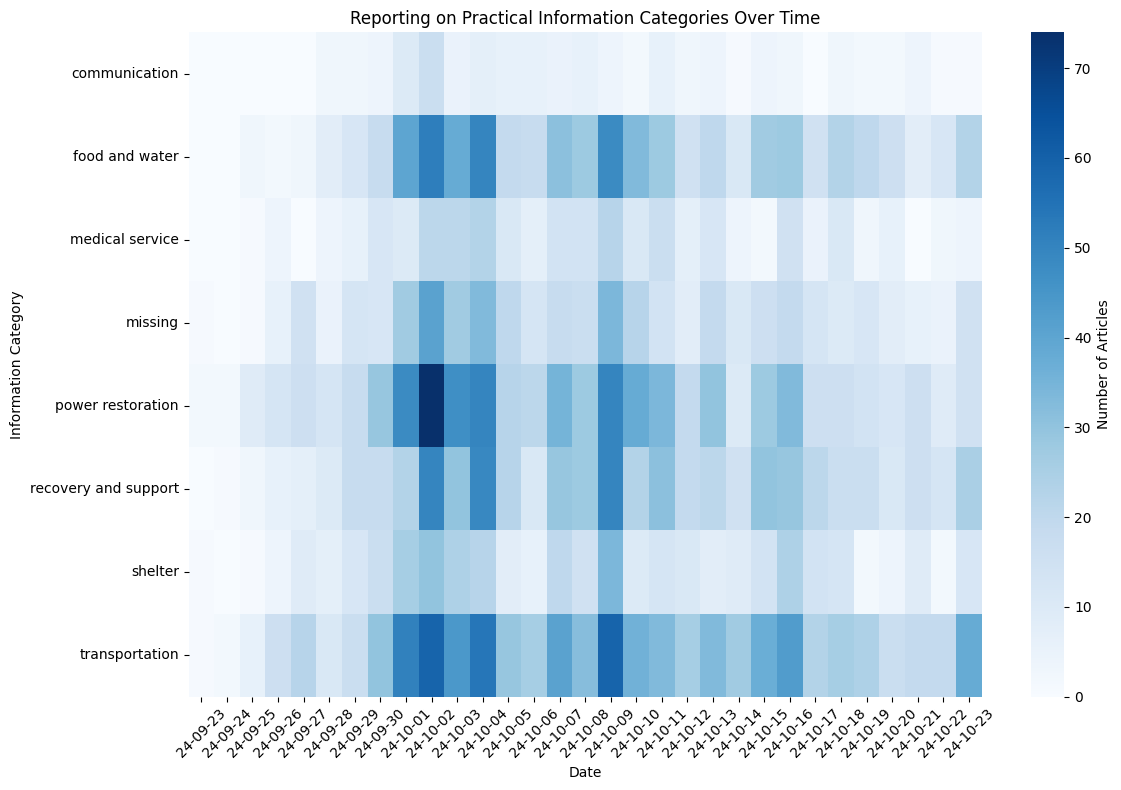

In [24]:
# Plotting the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.T, cmap="Blues", cbar_kws={'label': 'Number of Articles'})
plt.title('Reporting on Practical Information Categories Over Time')
plt.ylabel('Information Category')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Small multiples

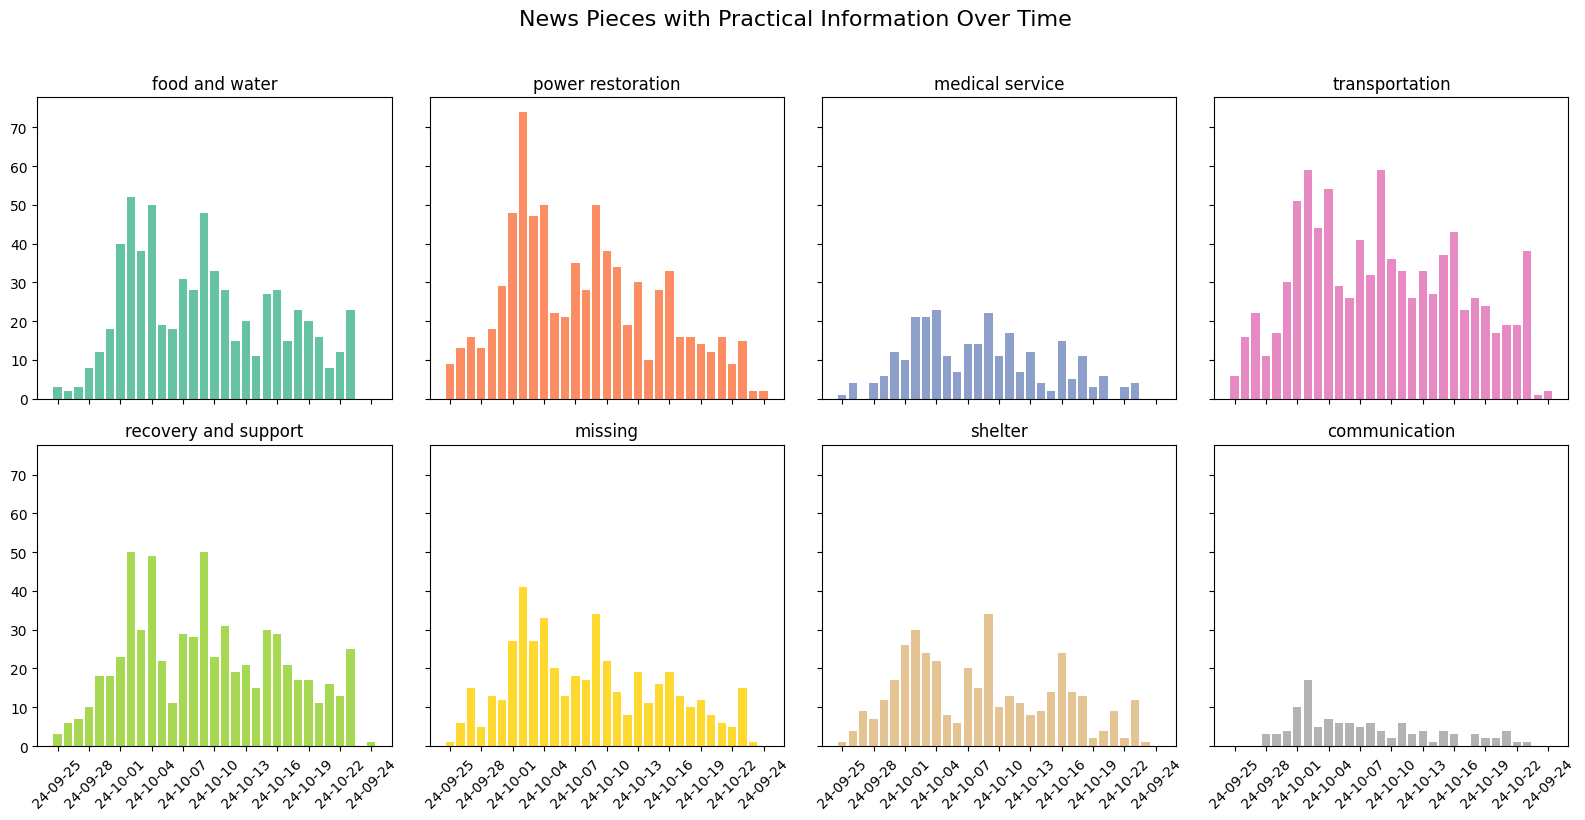

In [125]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
categories = df_exploded[df_exploded['information'].isna() == False]['information'].unique()
colors = sns.color_palette('Set2', len(categories))  # Generate distinct colors
i_color = 0
# plt.title("News Pieces with Practical Information Over Time")
fig.suptitle("News Pieces with Practical Information Over Time", fontsize=16, y=1.02)

for ax, category in zip(axes.flat, categories):
    sub_data = df_exploded[df_exploded['information'] == category].groupby('date')['article'].count().reset_index().sort_values("date")
    ax.bar(sub_data['date'], sub_data['article'], color=colors[i_color])
    ax.set_title(category)
    ax.tick_params(axis='x', rotation=45)
    i_color+=1

plt.xticks(ticks=ax.get_xticks()[::3])
plt.tight_layout()
plt.show()

Bar chart of sum

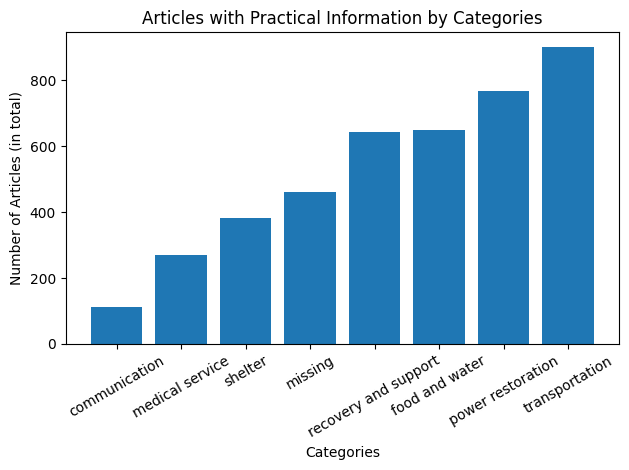

In [ ]:
df_count = df_exploded.groupby("information")['article'].count().reset_index().sort_values("article")

plt.bar(df_count['information'], df_count['article'])
plt.title("Articles with Practical Information by Categories")
plt.xlabel("Categories")
plt.ylabel("Number of Articles (in total)")
plt.xticks(rotation=30)
# plt.legend(title="Information Category", bbox_to_anchor=(1.05, 1), loc='upper left')
# for p in ax.patches: ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.tight_layout()
plt.show()

What portion of articles contain practical information?

In [45]:
len(articles[articles['information'].str.len() ==0])

274